In [1]:
import ross as rs
import numpy as np
import plotly.graph_objects as go
import complete_ross as fct

Q_ = rs.Q_
rs.__version__

'1.5.1'

In [2]:
def simulation(kA, kB, kC, kD):
    material_exo = rs.Material(name="mat_exo", rho=7850, E=2.05 * 10**11, Poisson= 0.3)

    # Birotor
        
    axial_shaft = [rs.ShaftElement(0.1, 0, 0.05, material=material_exo) for _ in range(8)]
    coaxial_shaft = [rs.ShaftElement(0.1, 0.07, 0.08, material=material_exo) for _ in range(4)]

    disks = [
        rs.DiskElement.from_geometry(n=1, material=material_exo, width=0.02, i_d=0.05, o_d=0.257),
        rs.DiskElement.from_geometry(n=7, material=material_exo, width=0.02, i_d=0.05, o_d=0.3),
        rs.DiskElement.from_geometry(n=11, material=material_exo, width=0.015, i_d=0.08, o_d=0.46)
    ]

    bearings = [
        rs.BearingElement(0, kxx=kA, kyy=kA, cxx=0), # A
        rs.BearingElement(8, kxx=kB, kyy=kB, cxx=0), # B
        rs.BearingElement(9, kxx=kC, kyy=kC, cxx=0), # C
        rs.BearingElement(6, n_link=13, kxx=kD, kyy=kD, cxx=0) # D
    ]
    ""
    # Création du rotor coaxial
    shaft = [axial_shaft, coaxial_shaft]
    rotor_coaxial = rs.CoAxialRotor(shaft, disks, bearings)

    # Simulation
    modal = rotor_coaxial.run_modal(speed=Q_(5000, "RPM"),num_modes=28)
    natural_frequencies = modal.wn
    return natural_frequencies[::2]

Nominal stiffness: 105805233.47125556


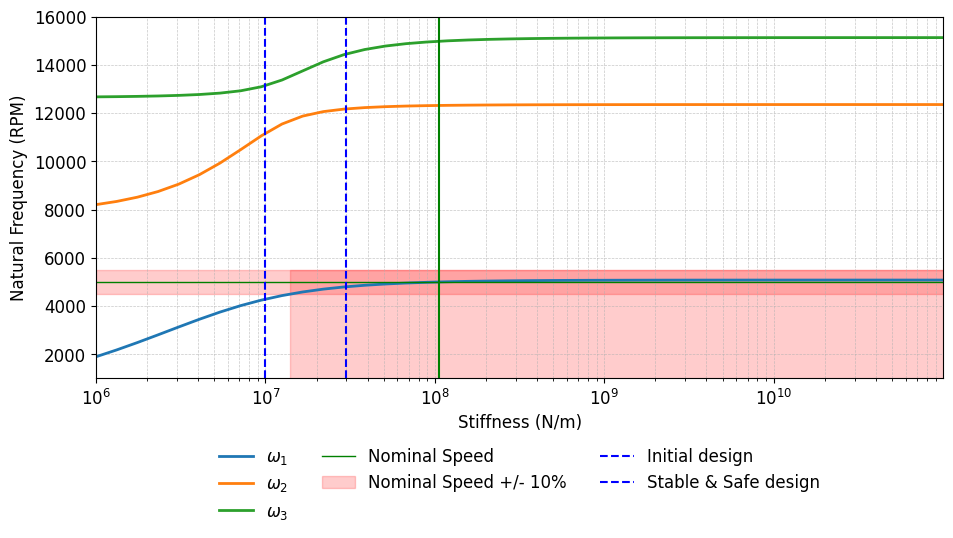

In [3]:
from matplotlib import pyplot as plt
from scipy.interpolate import CubicSpline

stiffness_vec = np.logspace(6, 11, 42)
natural_frequencies_array = np.array([simulation(3e7, kA, 2.5e7, 2.5e7) for kA in stiffness_vec])[:,:3]
# convert to RPM
natural_frequencies_array = natural_frequencies_array * 60 / (2 * np.pi)

# Interpolate functions for the first natural frequencies
natural_frequencies_functions = [CubicSpline(stiffness_vec, natural_frequencies_array[:, i]) for i in range(0, len(natural_frequencies_array.T))]

# Solve equation natural_frequency[0] = 5000 RPM using fsolve
from scipy.optimize import fsolve
nominal_speed = 5000
nominal_stiffness = fsolve(lambda x: natural_frequencies_functions[0](x) - nominal_speed, 1e7)[0]
print(f"Nominal stiffness: {nominal_stiffness}")

# Find min and max stiffness for +/- 10% of nominal speed
min_stiffness = fsolve(lambda x: natural_frequencies_functions[0](x) - nominal_speed * 0.9, 1e7)[0]
max_stiffness = fsolve(lambda x: natural_frequencies_functions[0](x) - nominal_speed * 1.1, 1e7)[0]

labels = [f'$\omega_{i+1}$' for i in range(0, len(natural_frequencies_array.T))]

plt.rcParams.update({'font.size': 12})  # Exemple avec une police Serif, taille 12, en gras

plt.figure(figsize=(10, 6))
for i in range(len(labels)):
    natural_frequencies_vec = natural_frequencies_array[:, i]
    plt.plot(stiffness_vec, natural_frequencies_vec, label=labels[i], linewidth=2)
plt.xscale("log")
plt.xlabel("Stiffness (N/m)")
plt.ylabel("Natural Frequency (RPM)")
plt.xticks(np.logspace(6, 10, 5))
plt.xlim(10**6, 10**11)

# Add the nominal speed vertical bar at 5000 RPM
plt.axhline(y=5000, color="green", linestyle="-", linewidth=1, label="Nominal Speed")

# Draw horizontal filled rectangle for +/- 10% of nominal speed, it should go from -10% to +10% of nominal speed
plt.fill_between([10**6, max_stiffness], nominal_speed * 0.9, nominal_speed * 1.1, color="red", alpha=0.2, label="Nominal Speed +/- 10%")

# Add the nominal stiffness vertical bar
plt.axvline(x=nominal_stiffness, color="green", linestyle="-")

# Add a vertical bar for k = 3e7
plt.axvline(x=3e7, color="blue", linestyle="--", label="Initial design")
plt.axvline(x=1e7, color="blue", linestyle="--", label="Stable & Safe design")

# Draw verticam filled rectangle for +/- 10% of nominal speed, it should go from min_stiffness to max_stiffness
plt.fill_between([min_stiffness, max_stiffness], 0, 5500, color="red", alpha=0.2)

plt.ylim(1000, 16000)

# putt legend at top right
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False, fontsize=12)

plt.tight_layout(pad=2)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.savefig("bearingstiffness.pdf", dpi=300, bbox_inches='tight')
plt.show()